<a href="https://colab.research.google.com/github/benzerer/chars2vec/blob/master/test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# uncomment เมื่อใช้ครั้งแรก (โหลด update chars2vec จาก git เลาเอง เนื่องจากต้นฉบับมีบั๊ก เลาแก้บั๊กให้แล้ว)
!wget https://github.com/Phonbopit/sarabun-webfont/raw/master/fonts/thsarabunnew-webfont.ttf
!wget https://github.com/benzerer/chars2vec/archive/refs/heads/master.zip
!unzip master.zip
!cp -r chars2vec\-master/chars2vec .
!pip install ngram

In [ ]:
# อันนี้คืออะไร ใช้ทำอะไรได้??
# ดูนี่ --> https://medium.com/hackernoon/chars2vec-character-based-language-model-for-handling-real-world-texts-with-spelling-errors-and-a3e4053a147d

In [ ]:
import chars2vec
import sklearn.decomposition
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
from ngram import NGram
import numpy as np

# set mathtext font fallback (อันนี้เยอะกว่าปกติหน่อย)
mpl.font_manager.fontManager.addfont('thsarabunnew-webfont.ttf')
mpl.rc('font', family='TH Sarabun New')
mpl.rc('mathtext', fontset='custom')
mpl.rc('mathtext', bf='TH Sarabun New')
mpl.rc('mathtext', cal='TH Sarabun New')
mpl.rc('mathtext', it='TH Sarabun New')
mpl.rc('mathtext', rm='TH Sarabun New')
mpl.rc('mathtext', sf='TH Sarabun New')
mpl.rc('mathtext', tt='TH Sarabun New')

In [ ]:
with open('/content/[2022-10-20] p0s_items.csv', 'r') as f:
  txts = f.readlines()

def clean_word (word):
  return (
      word
      .replace("\"", "")
      .replace("\\", "")
      .strip()
  )
txts = [word.replace("\"", "").strip() for word in txts[1:] if len(word) < 150]
txts = [word for word in txts if len(word) > 1]

27773


In [ ]:
len(txts)

27638

In [ ]:
col_a = np.random.choice(txts, 500)
col_b = np.random.choice(txts, 500)

In [ ]:
ng = NGram()

In [ ]:
df = pd.DataFrame(data=zip(col_a,col_b), columns=['a', 'b'])
df['score'] = (
    df
    .apply((lambda x: ng.compare(x.a, x.b)), axis=1)
    .apply(lambda x: 1 if x else 0)
    )
df

In [ ]:
X_train = (
    df[['a', 'b']]
    .apply((lambda x: (x.a, x.b)), axis=1)
    .tolist()
    )

In [ ]:
# จำนวน dimension ของ vector
dim = 100

# ใช้ save / load model
path = '/content/mod'

X_train = (
    df[['a', 'b']]
    .apply((lambda x: (x.a, x.b)), axis=1)
    .tolist()
    )

# คำที่เป็นสิ่งเดียวกัน ให้คะแนน 1 ต่างกันให้ 0
y_train = df.score.tolist()

# Bag of characters
model_chars = list(set(
    char
    for tup in X_train
    for word in tup
    for char in word
    ))

# Train & save
my_c2v_model = (
    chars2vec
    .train_model(
        dim,
        X_train,
        y_train,
        model_chars
        ))

chars2vec.save_model(my_c2v_model, path)
c2v_model = chars2vec.load_model(path)

# Try to create embeddings
words = col_a
word_embeddings = c2v_model.vectorize_words(words)

# PCA เนื่องจากมี 100 dimension
projection_2d = (
    sklearn
    .decomposition
    .PCA(n_components=2)
    .fit_transform(word_embeddings)
    )

Epoch 1/200
8/8 [==============================] - 16s 1s/step - loss: 0.4986 - val_loss: 0.4969
Epoch 2/200
8/8 [==============================] - 6s 774ms/step - loss: 0.4812 - val_loss: 0.5146
Epoch 3/200
8/8 [==============================] - 7s 836ms/step - loss: 0.4206 - val_loss: 0.5078
Epoch 4/200
8/8 [==============================] - 6s 783ms/step - loss: 0.3747 - val_loss: 0.4157
Epoch 5/200
8/8 [==============================] - 6s 771ms/step - loss: 0.3544 - val_loss: 0.4169
Epoch 6/200
8/8 [==============================] - 6s 781ms/step - loss: 0.3302 - val_loss: 0.3769
Epoch 7/200
8/8 [==============================] - 6s 805ms/step - loss: 0.3186 - val_loss: 0.3587
Epoch 8/200
8/8 [==============================] - 7s 840ms/step - loss: 0.2967 - val_loss: 0.3339
Epoch 9/200
8/8 [==============================] - 8s 982ms/step - loss: 0.3015 - val_loss: 0.3348
Epoch 10/200
8/8 [==============================] - 7s 833ms/step - loss: 0.3094 - val_loss: 0.3790
Epoch 11/20

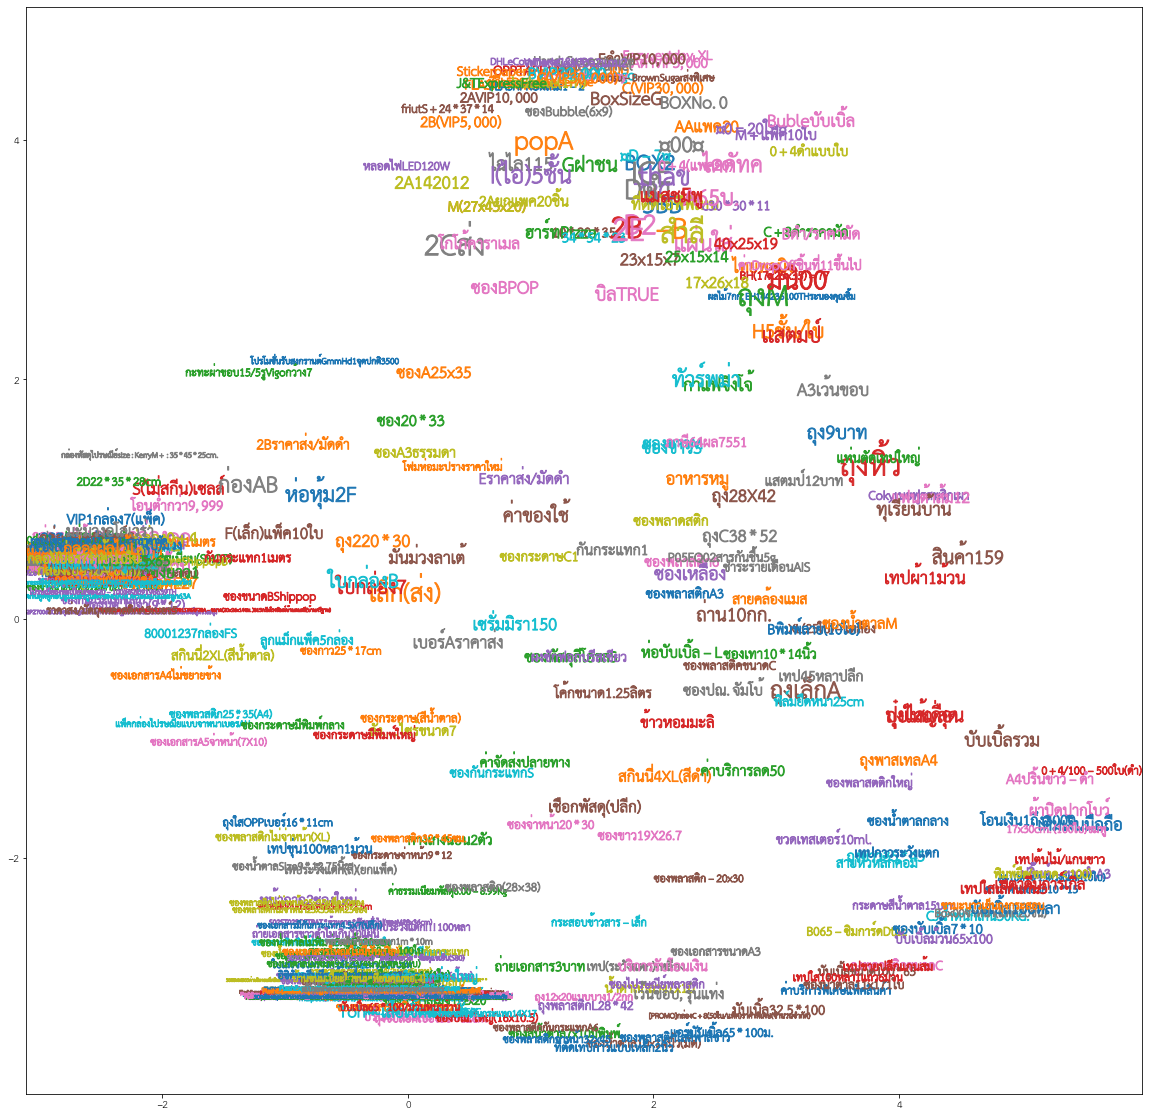

In [ ]:
# ลอง Plot ดู
f = plt.figure(figsize=(20, 20))

for idx, ctx in enumerate(projection_2d):
    plt.scatter(ctx[0], ctx[1],
                marker=('$' + words[idx] + '$'),
                s=500 * len(words[idx]), 
                label=idx)

plt.show()

In [ ]:
# ถ้า data เราอยะกว่านี้ เราจะจัดกลุ่มยังไงต่อ อาจจะลองอันนี้ --> https://scikit-learn.org/stable/modules/generated/sklearn.cluster.AgglomerativeClustering.html